In [7]:
import pandas as pd
import numpy as np
import torch
import torch.nn as nn
from torch.utils.data import DataLoader, TensorDataset
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler, OneHotEncoder
from sklearn.compose import ColumnTransformer
from sklearn.metrics import mean_absolute_error, r2_score
import matplotlib.pyplot as plt

In [8]:
# Load California Housing dataset
from sklearn.datasets import fetch_california_housing

data = fetch_california_housing()
X = data.data
y = data.target

device = torch.device("cuda" if torch.cuda.is_available() else "cpu")



In [9]:


# Scale numeric features
scaler = StandardScaler()
X_scaled = scaler.fit_transform(X)

# Train-test split
x_train, x_test, y_train, y_test = train_test_split(X_scaled, y, test_size=0.2, random_state=42)

# Convert to PyTorch tensors
import torch
from torch.utils.data import TensorDataset, DataLoader

x_train_tensor = torch.tensor(x_train, dtype=torch.float32)
y_train_tensor = torch.tensor(y_train, dtype=torch.float32).view(-1, 1)
x_test_tensor = torch.tensor(x_test, dtype=torch.float32)
y_test_tensor = torch.tensor(y_test, dtype=torch.float32).view(-1, 1)

train_ds = TensorDataset(x_train_tensor, y_train_tensor)
train_dl = DataLoader(train_ds, batch_size=64, shuffle=True)


In [10]:
class DeepANN(nn.Module):
    def __init__(self, input_dim):
        super().__init__()
        self.net = nn.Sequential(
            nn.Linear(input_dim, 128),
            nn.BatchNorm1d(128),
            nn.ReLU(),
            nn.Dropout(0.3),
            nn.Linear(128, 64),
            nn.ReLU(),
            nn.Linear(64, 1)
        )
    def forward(self, x):
        return self.net(x)
class TabularCNN(nn.Module):
    def __init__(self, input_dim):
        super().__init__()
        self.conv1 = nn.Conv1d(1, 16, kernel_size=3, padding=1)
        self.relu = nn.ReLU()
        self.fc1 = nn.Linear(16 * input_dim, 64)
        self.out = nn.Linear(64, 1)
    def forward(self, x):
        x = x.unsqueeze(1)  # shape: (batch, 1, features)
        x = self.relu(self.conv1(x))
        x = x.view(x.size(0), -1)  # flatten
        x = self.relu(self.fc1(x))
        return self.out(x)

class AutoencoderRegressor(nn.Module):
    def __init__(self, input_dim):
        super().__init__()
        self.encoder = nn.Sequential(
            nn.Linear(input_dim, 64),
            nn.ReLU(),
            nn.Linear(64, 32),
            nn.ReLU()
        )
        self.decoder = nn.Sequential(
            nn.Linear(32, 64),
            nn.ReLU(),
            nn.Linear(64, input_dim)
        )
        self.regressor = nn.Linear(32, 1)

    def forward(self, x):
        encoded = self.encoder(x)
        _ = self.decoder(encoded)  # ignored in output but forces good encoding
        return self.regressor(encoded)
class ResidualANN(nn.Module):
    def __init__(self, input_dim):
        super().__init__()
        self.input_layer = nn.Linear(input_dim, 128)
        self.hidden = nn.Sequential(
            nn.ReLU(),
            nn.Linear(128, 128),
            nn.ReLU(),
            nn.Linear(128, 128)
        )
        self.output_layer = nn.Sequential(
            nn.ReLU(),
            nn.Linear(128, 1)
        )
    def forward(self, x):
        x = self.input_layer(x)
        residual = x
        x = self.hidden(x)
        x = x + residual
        return self.output_layer(x)

# Model 5: VAE-style Regressor
class VAERegressor(nn.Module):
    def __init__(self, input_dim):
        super().__init__()
        self.encoder = nn.Sequential(
            nn.Linear(input_dim, 64),
            nn.ReLU()
        )
        self.mu = nn.Linear(64, 32)
        self.logvar = nn.Linear(64, 32)
        self.decoder = nn.Sequential(
            nn.Linear(32, 64),
            nn.ReLU(),
            nn.Linear(64, input_dim)
        )
        self.regressor = nn.Linear(32, 1)
    def forward(self, x):
        x_encoded = self.encoder(x)
        mu = self.mu(x_encoded)
        logvar = self.logvar(x_encoded)
        std = torch.exp(0.5 * logvar)
        z = mu + std * torch.randn_like(std)
        _ = self.decoder(z)
        return self.regressor(z)



In [11]:
def train_model(model, train_dl, epochs=50):
    model.to(device)
    loss_fn = nn.MSELoss()
    optimizer = torch.optim.Adam(model.parameters(), lr=0.001)

    for epoch in range(epochs):
        model.train()
        for xb, yb in train_dl:
            xb, yb = xb.to(device), yb.to(device)
            preds = model(xb)
            loss = loss_fn(preds, yb)
            optimizer.zero_grad()
            loss.backward()
            optimizer.step()
    return model

# Evaluation
def evaluate(model, x_test, y_test):
    model.eval()
    with torch.no_grad():
        preds = model(x_test.to(device)).cpu().squeeze().numpy()
    mae = mean_absolute_error(y_test.numpy(), preds)
    r2 = r2_score(y_test.numpy(), preds)
    return preds, mae, r2


In [12]:
input_dim = x_train.shape[1]
models = [
    DeepANN(input_dim),
    TabularCNN(input_dim),
    AutoencoderRegressor(input_dim),
    ResidualANN(input_dim),
    VAERegressor(input_dim)
]

results = []

for i, model in enumerate(models):
    print(f"Training Model {i+1}...")
    model = train_model(model, train_dl)
    preds, mae, r2 = evaluate(model, x_test_tensor, y_test_tensor)
    results.append((f"Model {i+1}", mae, r2, preds))
    print(f"Model {i+1} -> MAE: {mae:.2f}, R²: {r2:.2f}")

Training Model 1...
Model 1 -> MAE: 0.42, R²: 0.70
Training Model 2...
Model 2 -> MAE: 0.37, R²: 0.79
Training Model 3...
Model 3 -> MAE: 0.37, R²: 0.77
Training Model 4...
Model 4 -> MAE: 0.34, R²: 0.79
Training Model 5...
Model 5 -> MAE: 0.42, R²: 0.74


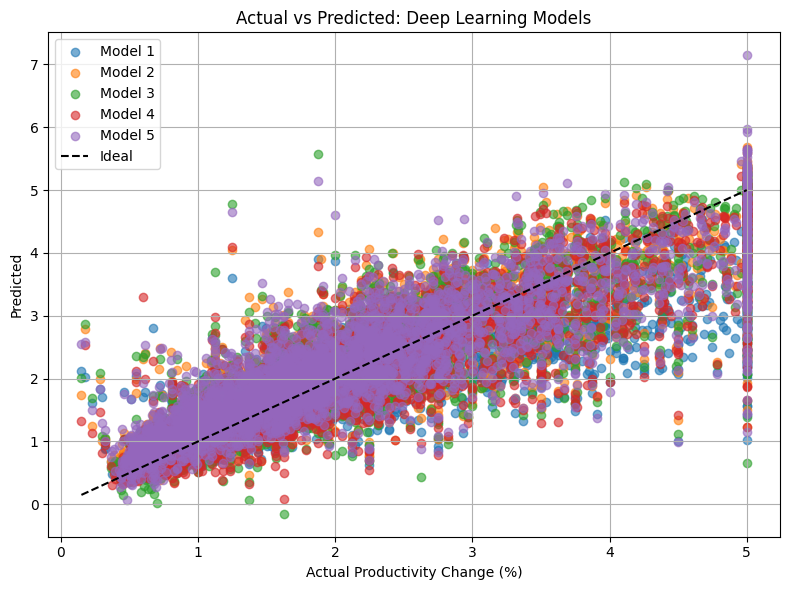

In [13]:
plt.figure(figsize=(8, 6))
for name, _, _, preds in results:
    plt.scatter(y_test, preds, alpha=0.6, label=name)
plt.plot([min(y_test), max(y_test)], [min(y_test), max(y_test)], 'k--', label='Ideal')
plt.xlabel("Actual Productivity Change (%)")
plt.ylabel("Predicted")
plt.title("Actual vs Predicted: Deep Learning Models")
plt.legend()
plt.grid(True)
plt.tight_layout()
plt.show()
